# Estimating object location from noisy radar echos

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mkl

from IPython.display import display, HTML
from matplotlib.animation import FuncAnimation

np.random.seed(1234)
mkl.set_num_threads(2)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = [16, 9]

## Useful imports

In [2]:
from scipy.stats import multivariate_normal as mvn
from numpy.linalg import inv

## Useful utility functions

In [3]:
# Plot 'iso-densities' for MVN
#   ax - axis for plotting,
#   mu, Sigma - MVN parameters,
#   observations - observations (data points) to mark on the plot,
#   title - plot title.
def plot_mvn(ax, mu, Sigma, observations = None, title = None,
             xmin = -10, xmax = 10, ymin = -10, ymax = 10, grid_size = 100):
    X = np.linspace(xmin, xmax, grid_size)
    Y = np.linspace(ymin, ymax, grid_size)
    X, Y = np.meshgrid(X, Y)
    grid = np.vstack([X.flatten(), Y.flatten()]).T
    
    p = mvn(mu, Sigma)
    density = p.pdf(grid).reshape((grid_size, grid_size))

    ax.contour(X, Y, density, zorder = 1)
    
    if observations is not None:
        if len(observations.shape) == 1:
            ox, oy = observations[0], observations[1]
        else:
            ox, oy = observations[:, 0], observations[:, 1]
            
        ax.scatter(ox, oy, s = 100, c = 'r', marker = 'x', zorder = 2)
    
    if title is not None:
        ax.set_title(title)
    
    ax.axis('equal')
    plt.show

## Estimating object location from (one) noisy radar echo

Our task is to estimate location of a stationary object from its radar echo.

Assumptions:
- radar plane is a $[-10, 10] \times [-10, 10]$ rectangle,
- radar echo gives us a noisy measurement of the true location,
- the measurement noise is well modeled by a multivariate Gaussian with precision: `radar_echo_Prec`.

In [4]:
radar_echo_Sigma = np.array([[2, -1.5],
                             [-1.5, 2]])

radar_echo_Prec = inv(radar_echo_Sigma)

For now, we have only one radar echo to work with. It is stored in: `radar_echo`.

In the code below, `true_x` is the true location of the object on the radar plane. We imagine that we do not know this location (our task is to estimate it).

In [5]:
true_x = np.array([5.0, 5.0])

radar_echo = mvn.rvs(true_x, radar_echo_Sigma, size = 1, random_state = 1234)

---

Propose (and be ready to justify) a probabilistic model for estimating object location from the radar echo. This model must:
1. estimate a likely location of the object,
1. estimate uncertainty in the (estimated) object location.

From working experience with our radar we know that objects are most often located in a sphere with radius $r=3$ centered in the radar plane.

---

Implement the proposed model in `estimate_location_from_echo` function. The arguments to this function should be:
- radar echo,
- parameters of the probability distribution that expresses our prior assumptions about object location.

`estimate_location_from_echo` should return parameters of the probability distribution that expresses our beliefs about object location after observing one radar echo.

As a model let's use **Linear Gaussian Model** for that case because of our last assumption - let's bring it here:
- the measurement noise is well modeled by a **multivariate Gaussian** with precision: `radar_echo_Prec`.

So it fits here. Therefore we consider ```radar_echo``` as a measurement ($y$) of an unknown variable ($x$), whose estimation is our target. As in this model, $x$ is also modeled by a multivariate Gaussian. According to given information, its Mean is $[0, 0]^T$ and Covariance Matrix is
\begin{matrix}
    |3.0 & 0.0| \\
    |0.0 & 3.0|.
\end{matrix}
Looking at the equation from lecture: $y = Ax + b + \epsilon$, we notice that $A$ is Identity Matrix,  $b$ is column filled with zeros and $\epsilon$ is random error (which means that its Mean = 0), whose Precision Matrix is `radar_echo_Prec`.

In [6]:
# global variables - we treat them as known in our probabilistic model
A = np.identity(2)
b = np.zeros(shape = (2,))

# parametres expressing our prior assumptions about object location
x_mu = np.zeros(shape = (2,))
x_Sigma = np.array([[3., 0],
                    [0, 3.]])

In [7]:
def estimate_location_from_echo(radar_echo, x_mu, x_Sigma):
    result_Sigma = inv(inv(x_Sigma) + np.dot(np.dot(np.transpose(A), radar_echo_Prec), A))
    result_mu = np.dot(result_Sigma, np.dot(np.dot(np.transpose(A), radar_echo_Prec), (radar_echo - b)) + np.dot(inv(x_Sigma), x_mu))
    return result_mu, result_Sigma

Now, use `estimate_location_from_echo` to estimate object location (and uncertainty). Then use `plot_mvn` function to plot two 'iso-density' plots:
- one for our prior assumptions about object location - this should be plotted in `ax[0]` axes,
- one for estimated object location and its uncertainty - this should be plotted in `ax[1]` axes and include location of the radar echo.

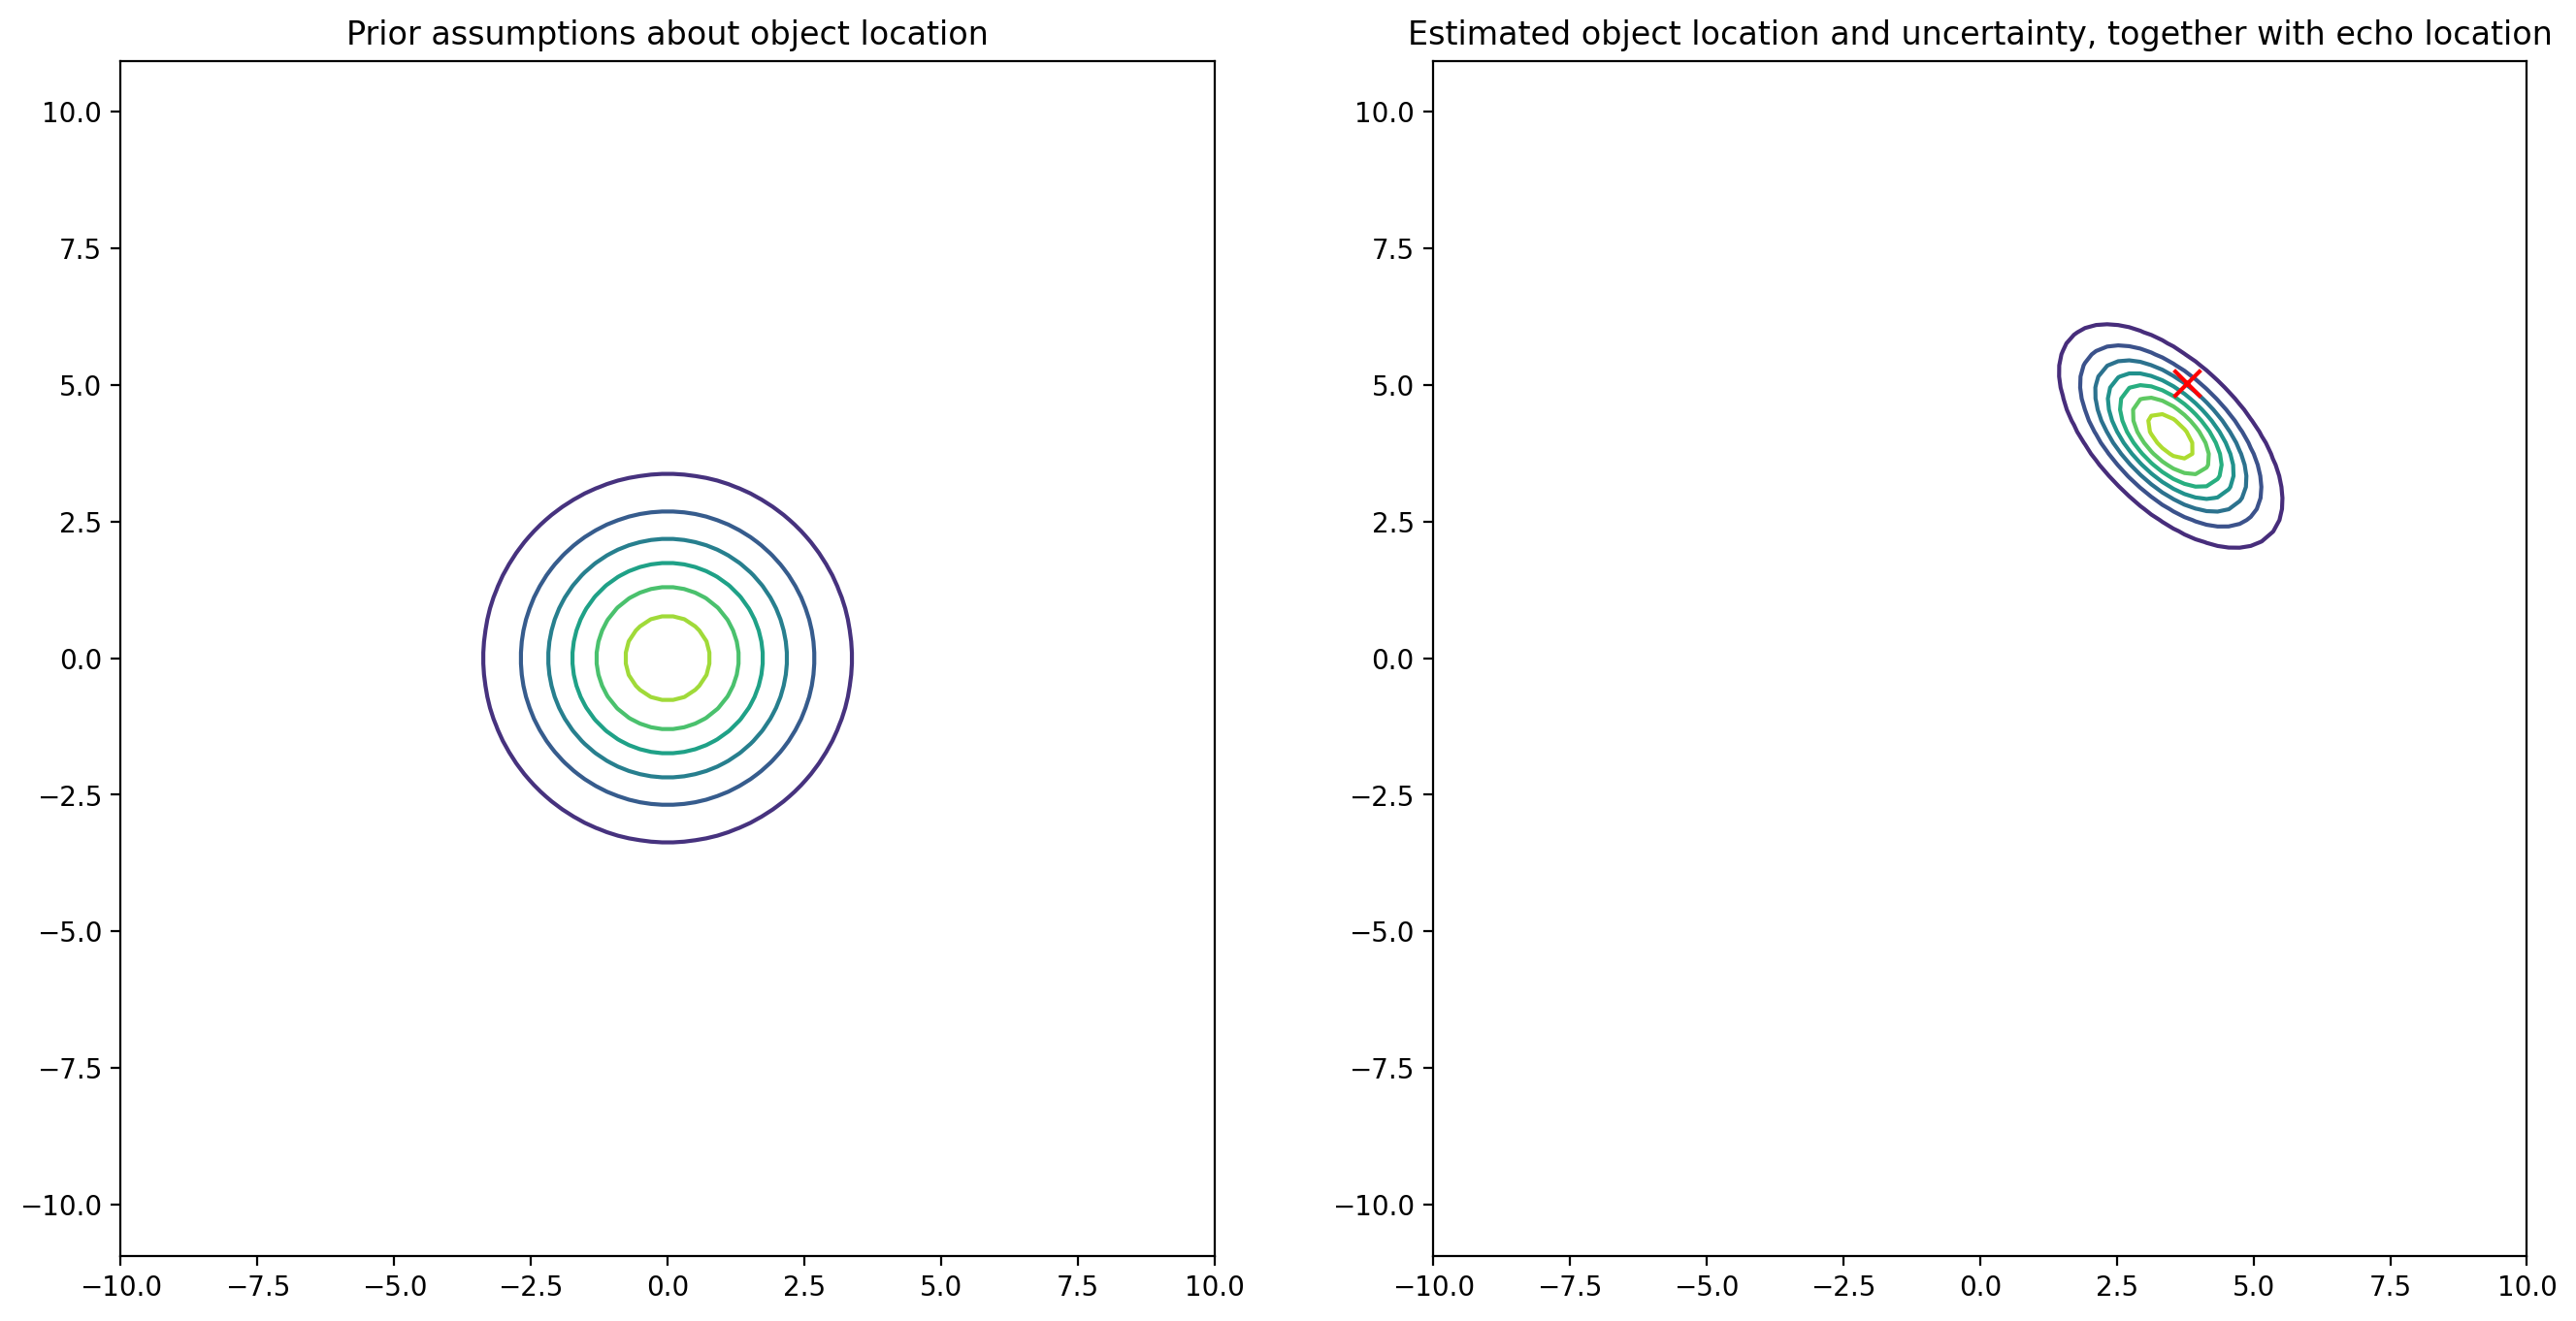

In [8]:
_, ax = plt.subplots(1, 2, figsize = (16, 8))
result_mu1, result_Sigma1 = estimate_location_from_echo(radar_echo, x_mu, x_Sigma)

plot_mvn(ax[0], x_mu, x_Sigma, title = 'Prior assumptions about object location')
plot_mvn(ax[1], result_mu1, result_Sigma1, radar_echo, title = 'Estimated object location and uncertainty, together with echo location') 

## Estimating object location from multiple noisy radar echos

Now imagine that we have $N$ radar echos for a single object (we made $N$ independent radar scans). These echos are stored in `radar_echo_n`.

In [9]:
N = 5

radar_echo_n = mvn.rvs(true_x, radar_echo_Sigma, size = N, random_state = 1234)

Our goal is to estimate object location (and uncertainty) from all these radar scans. One simple option is to iteratively update our beliefs about object location as new echos arrive.

That is:
- we start with prior assumptions about object location,
- we update our beliefs about object location when we observe a radar echo,
- once we observe another radar echo, we can treat our current beliefs about object location (estimated above) as prior assumptions,
- we can continue in this iterative manner until we accounted for evidence from all observed echos.

---

Implement the iterative procedure described above to estimate object location (and uncertainty) from all radar echos stored in `radar_echo_n`. Use `estimate_location_from_echo` function for updating beliefs about object location.

In [10]:
def estimate_location_from_echo_iterative(radar_echos, x_mu, x_Sigma):
    iter_mu = x_mu
    iter_Sigma = x_Sigma
    N = radar_echos.shape[0]
    
    for i in range(N):
        result_mu, result_Sigma = estimate_location_from_echo(radar_echo_n[i, :], iter_mu, iter_Sigma)
        iter_mu = result_mu
        iter_Sigma = result_Sigma

    return result_mu, result_Sigma

Use `plot_mvn` function to plot two 'iso-density' plots:
- one for prior assumptions about object location - this should be plotted in `ax[0]` axes,
- one for estimated object location and its uncertainty - this should be plotted in `ax[1]` axes and include locations of all radar echos stored in `radar_echo_n`.

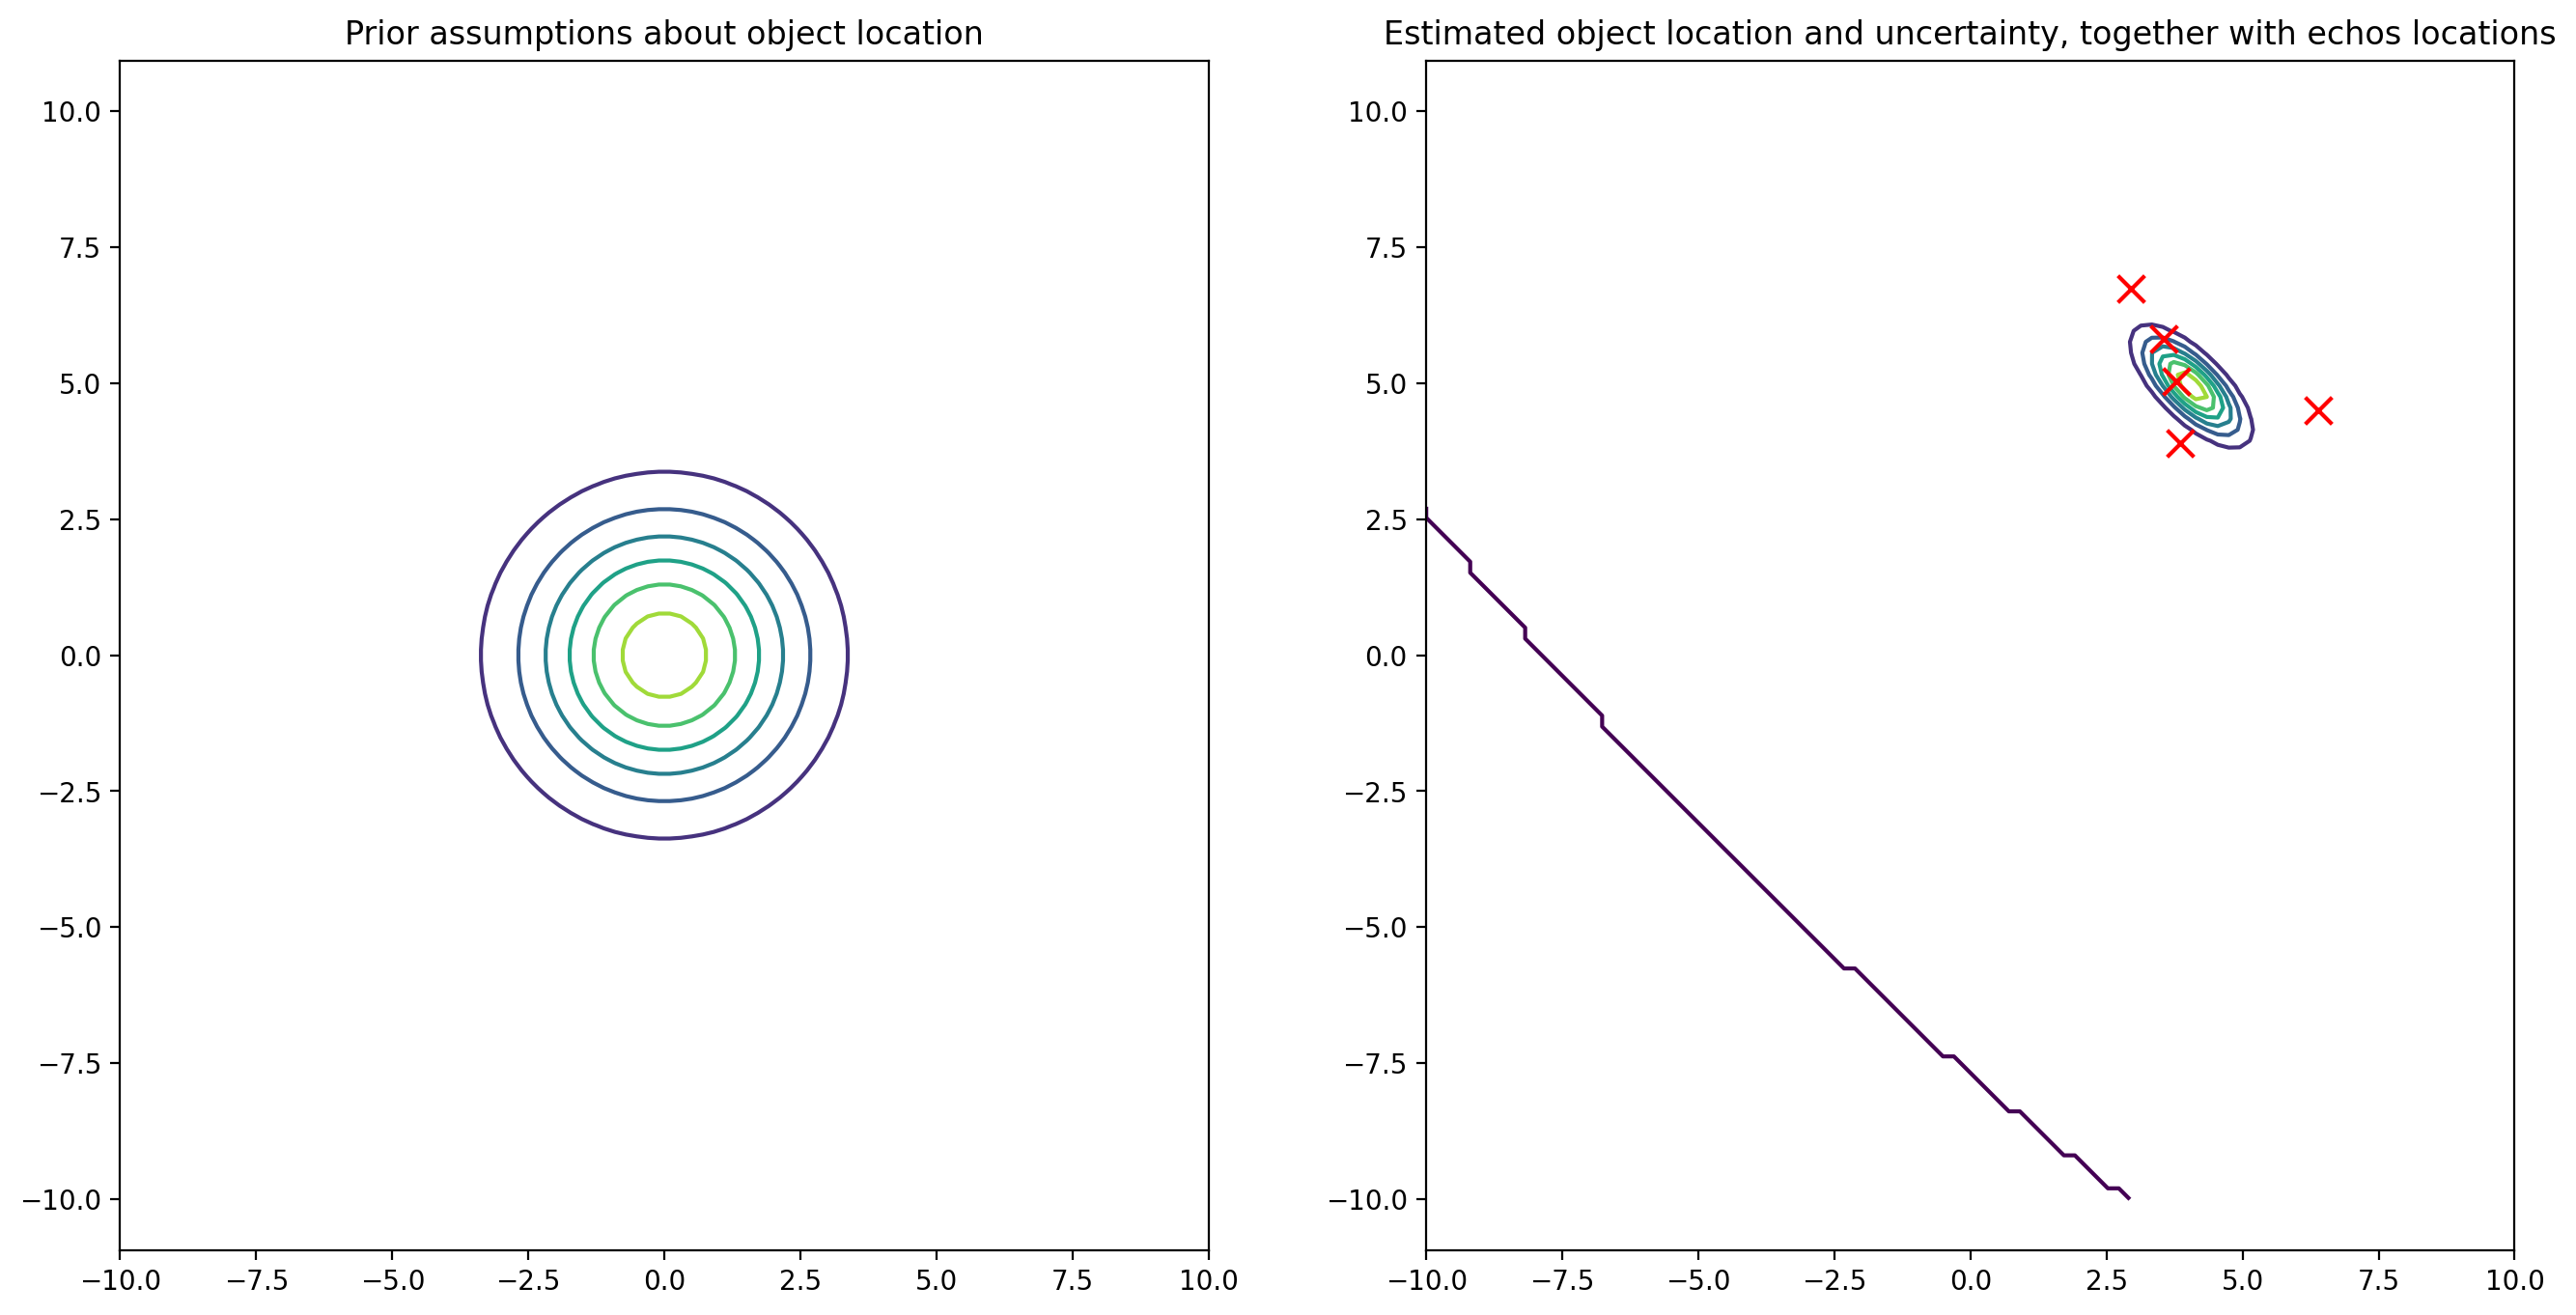

In [11]:
_, ax = plt.subplots(1, 2, figsize = (16, 8))
result_mu2, result_Sigma2 = estimate_location_from_echo_iterative(radar_echo_n, x_mu, x_Sigma)

plot_mvn(ax[0], x_mu, x_Sigma, title = 'Prior assumptions about object location')
plot_mvn(ax[1], result_mu2, result_Sigma2, radar_echo_n, title = 'Estimated object location and uncertainty, together with echos locations') 

The iterative update procedure implemented above has one drawback - it's not efficient (computationally).

If you came up with a sensible probabilistic model it should be possible to derive equations for estimating object location (and uncertainty) from all radar echos (in a single pass). Try to write down these equations and implement them in `estimate_location_from_echo_batch` function. The arguments to this function should be:
- radar echos (in a NumPy array),
- parameters of the probability distribution that expresses our prior assumptions about object location.

`estimate_location_from_echo_batch` should return parameters of the probability distribution that expresses our beliefs about object location after observing all radar echos.

---

Hint: try to write down parameters of the probability distribution over object location after:
- observing one echo, e.g. $e_1$,
- then observing another echo, e.g. $e_2$.

Guess a form of the batch-update equations from these examples. Then prove by induction that it is correct.

In [12]:
def estimate_location_from_echo_batch(radar_echos, x_mu, x_Sigma):
    N = radar_echos.shape[0]
    result_Sigma = inv(inv(x_Sigma) + N * radar_echo_Prec)
    result_mu = np.dot(result_Sigma, np.dot(radar_echo_Prec, np.sum(radar_echos, axis = 0)))
    return result_mu, result_Sigma

Use `estimate_location_from_echo_batch` to estimate object location (and uncertainty) from all radar echos.

Next, use `plot_mvn` function to make 'iso-density' plots identical to the ones above, but using location and uncertainty estimates from `estimate_location_from_echo_batch`.

Verify that estimates from `estimate_location_from_echo_batch` agree with the ones from the iterative update procedure.

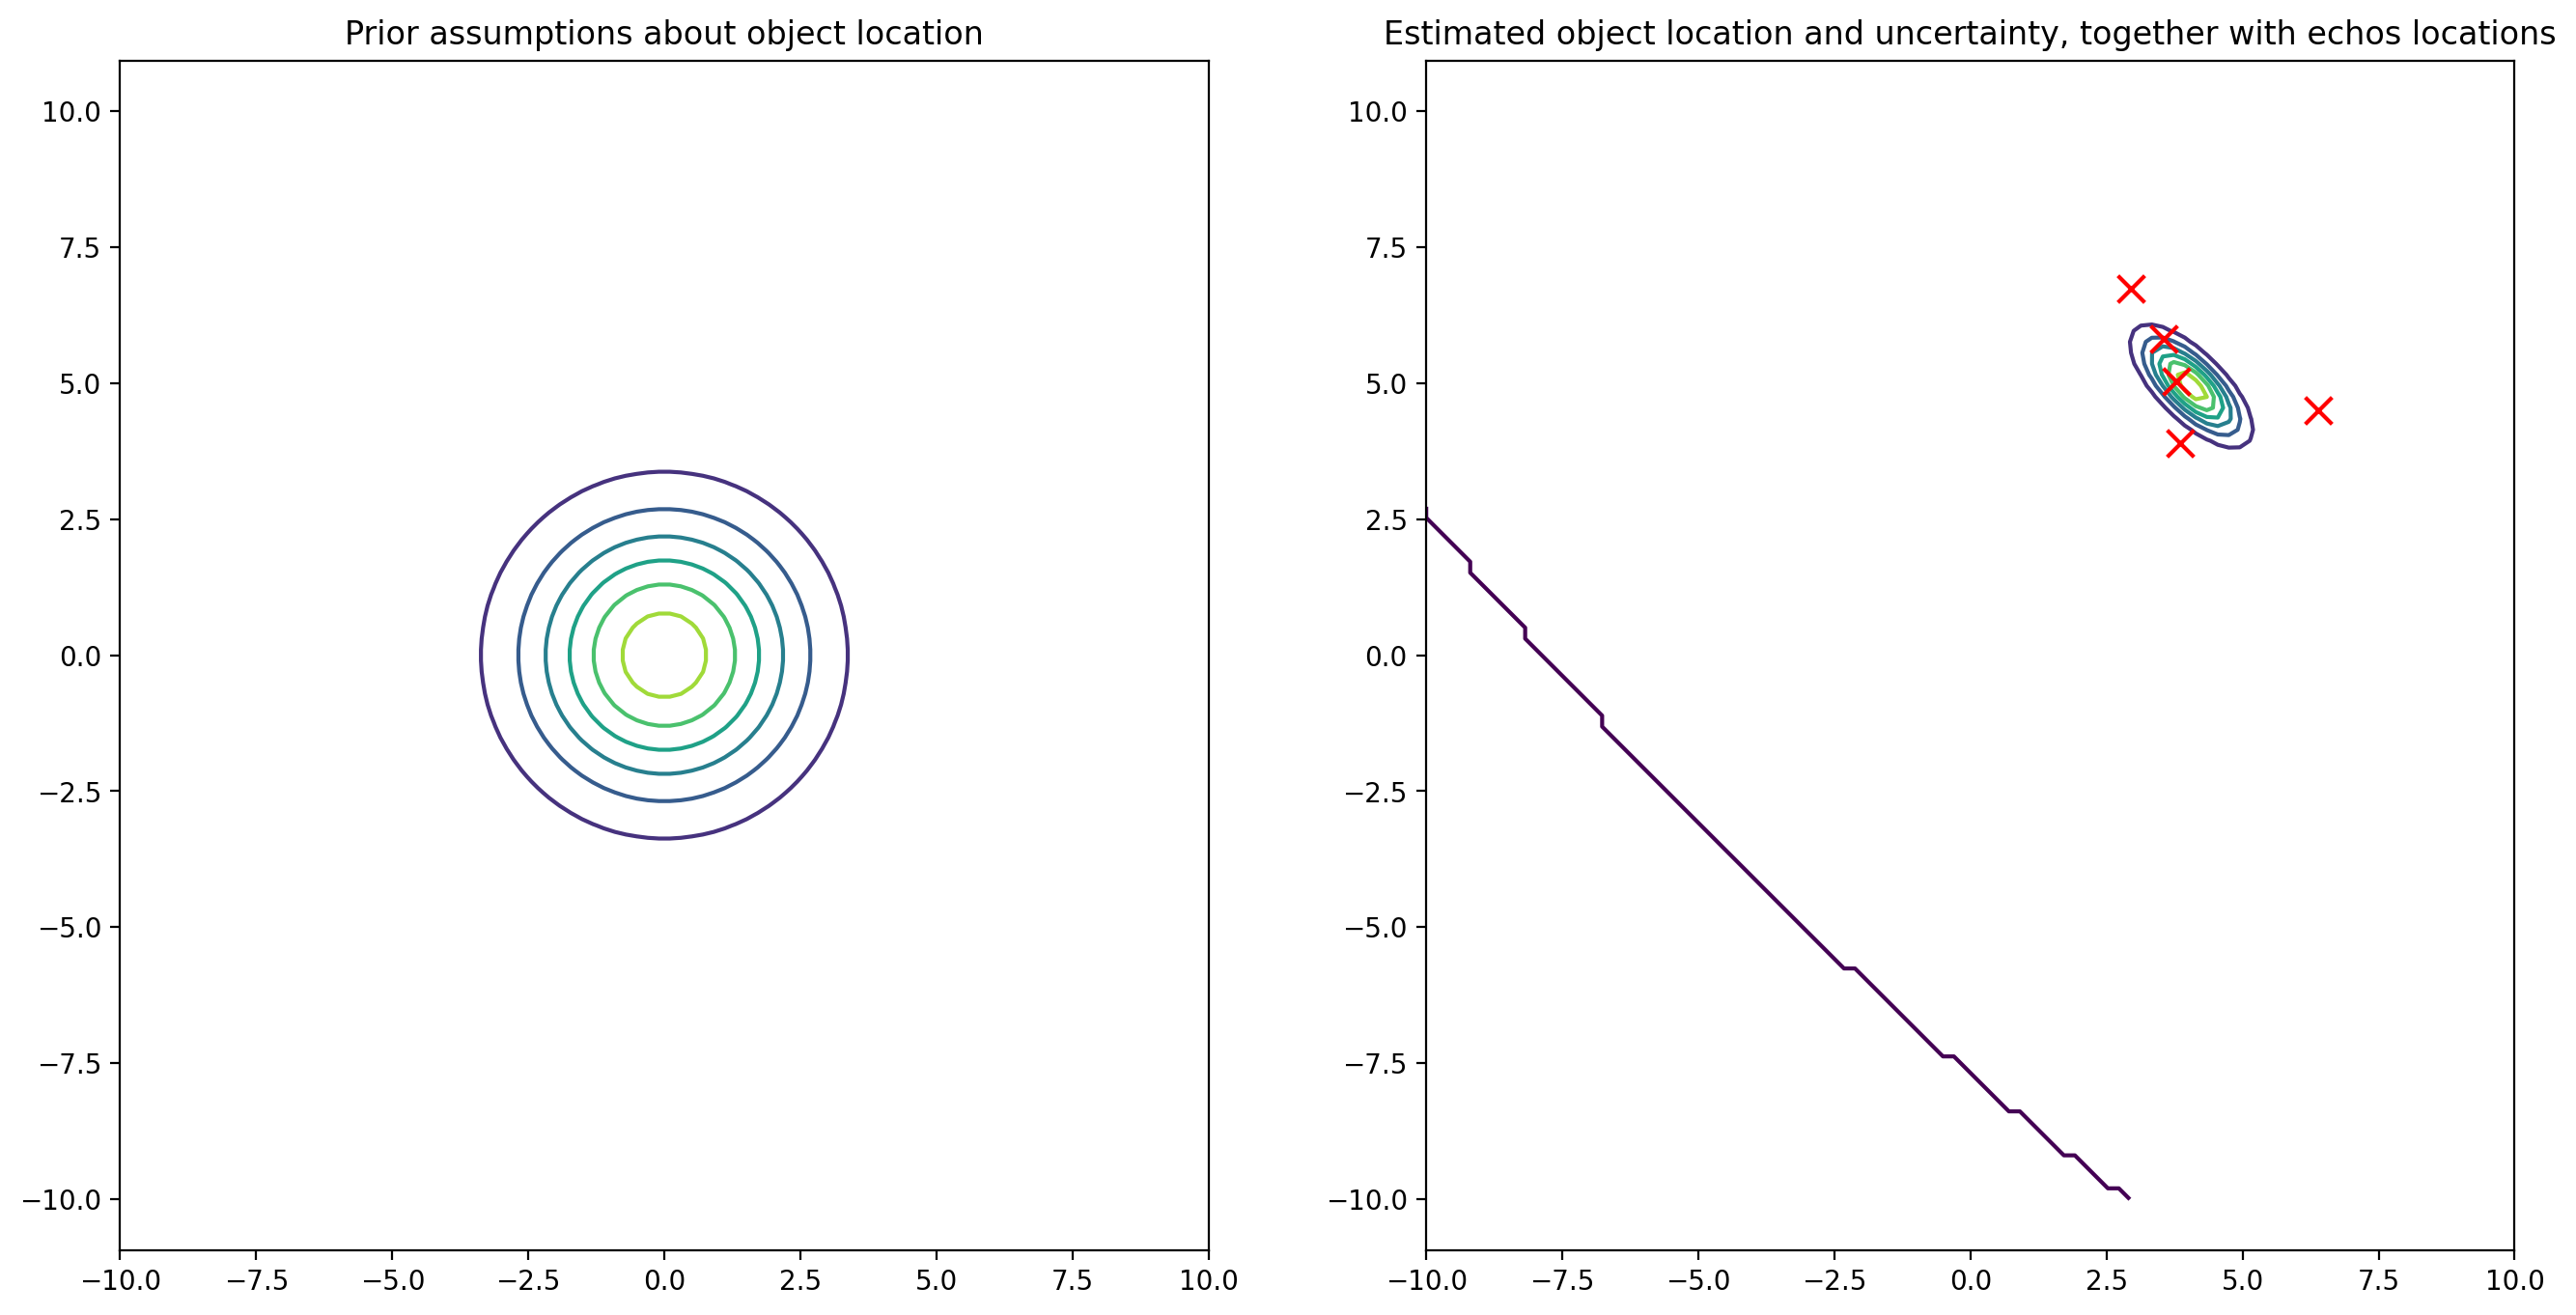

In [13]:
_, ax = plt.subplots(1, 2, figsize = (16, 8))
result_mu3, result_Sigma3 = estimate_location_from_echo_batch(radar_echo_n, x_mu, x_Sigma)

plot_mvn(ax[0], x_mu, x_Sigma, title = 'Prior assumptions about object location')
plot_mvn(ax[1], result_mu3, result_Sigma3, radar_echo_n, title = 'Estimated object location and uncertainty, together with echos locations') 

Graphically, the plot on the right looks identical to the one calculated using results from iterative procedure. Let's verify if they are identical indeed.

In [14]:
print("Iterative procedure results:")
print("Mean:", result_mu2, "\nCovariance Matrix:", result_Sigma2)
print()
print("Batch procedure results:")
print("Mean:", result_mu3, "\nCovariance Matrix:", result_Sigma3)

Iterative procedure results:
Mean: [4.05875599 4.94208147] 
Covariance Matrix: [[ 0.33217088 -0.23539669]
 [-0.23539669  0.33217088]]

Batch procedure results:
Mean: [4.05875599 4.94208147] 
Covariance Matrix: [[ 0.33217088 -0.23539669]
 [-0.23539669  0.33217088]]


Essentially, they are the same. Now let's prove by induction why the "batch approach" works here. We will be benefitting the fact that our model is simple in many cases - i. e. $A$ is Identity Matrix, so it can be omitted in multiplication, as well as $b$ is column filled with zeros - thus we can omit it in the addition. It makes using equations presented on lecture and proving process a lot easier.  

Important equations from lecture that I will be referring to - simplified because of our model:
- $\Sigma_1 = [\Sigma_0^{-1} + \Sigma_y^{-1}]^{-1}$ (1)
- $\mu_1 = \Sigma_1 \cdot [\Sigma_y^{-1} \cdot y_1 + \Sigma_0^{-1} \cdot \mu_0]$ (2)

where $\Sigma_y^{-1}$ is no other than ```radar_echo_Prec```, $y_1$ is initial echo observation and $\mu_0$, $\Sigma_0$ are given prior distribution parameters.

Let's start with an equation for **Covariance Matrix**. Our hypothesis is that for $N$ observations, $\Sigma_N = [\Sigma_0^{-1} + N \cdot \Sigma_y^{-1}]^{-1}$. The base of induction is that for $N = 1$ it works - compare with (1). Induction assumption is that for some $k$ we have $\Sigma_k = [\Sigma_0^{-1} + k \cdot \Sigma_y^{-1}]^{-1}$. For $k + 1$ we have:
\begin{gather*}
    \Sigma_{k + 1} = [\Sigma_k^{-1} + \Sigma_y^{-1}]^{-1} \textrm{ | we use (1) directly, treating } \Sigma_k \textrm{ as prior parameter} \\
    \Sigma_{k + 1} = [\Sigma_0^{-1} + k \cdot \Sigma_y^{-1} + \Sigma_y^{-1}]^{-1} \textrm{ | we use induction assumption} \\
    \Sigma_{k + 1} = [\Sigma_0^{-1} + (k + 1) \cdot \Sigma_y^{-1}]^{-1}
\end{gather*}
So this equation holds for all $N$. Quod Erat Demonstrandum

Now take a look at a proposition for **Mean**. Our hypothesis is that for $N$ observations, $\mu_N = \Sigma_N \cdot [\Sigma_y^{-1} \cdot (y_1 + y_2 + ... + y_N)]$. The base of induction is that for $N = 1$ it works - compare with (2) and consider that $\mu_0$ is column filled with zeros. Induction assumption is that for some $k$ we have $\mu_k = \Sigma_k \cdot [\Sigma_y^{-1} \cdot (y_1 + y_2 + ... + y_k)]$. For $k + 1$ we have:
\begin{gather*}
    \mu_{k + 1} = \Sigma_{k + 1} \cdot [\Sigma_y^{-1} \cdot y_{k + 1} + \Sigma_k^{-1} \cdot \mu_k] \textrm{ | we use (2) directly, treating } \Sigma_k \textrm{ and } \mu_k \textrm{ as prior parameters} \\
    \mu_{k + 1} = \Sigma_{k + 1} \cdot [\Sigma_y^{-1} \cdot y_{k + 1} + \Sigma_y^{-1} \cdot (y_1 + y_2 + ... + y_k)] \textrm{ | we use induction assumption - notice that } \Sigma_k^{-1} \cdot \Sigma_k \textrm{ cancel out} \\
    \mu_{k + 1} = \Sigma_{k + 1} \cdot [\Sigma_y^{-1} \cdot (y_1 + y_2 + ... + y_{k + 1})]
\end{gather*}
So this equation holds for all $N$. Quod Erat Demonstrandum